# EVAC Examination

## Data Exploration

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
import math
from sklearn.metrics import r2_score


In [221]:
num_input_nodes = 7
num_hidden_nodes_1 = 14
num_hidden_nodes_2 = 14
num_output_nodes = 1

NUM_WEIGHTS = (num_input_nodes * num_hidden_nodes_1) + (num_hidden_nodes_1 * num_hidden_nodes_2) + (num_hidden_nodes_2 * num_output_nodes)
NUM_BIASES = num_hidden_nodes_1 + num_hidden_nodes_2 + num_output_nodes

IND_SIZE = NUM_WEIGHTS + NUM_BIASES

In [222]:
all_data = pd.read_csv('eScooterDemand.csv')
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No,Yes


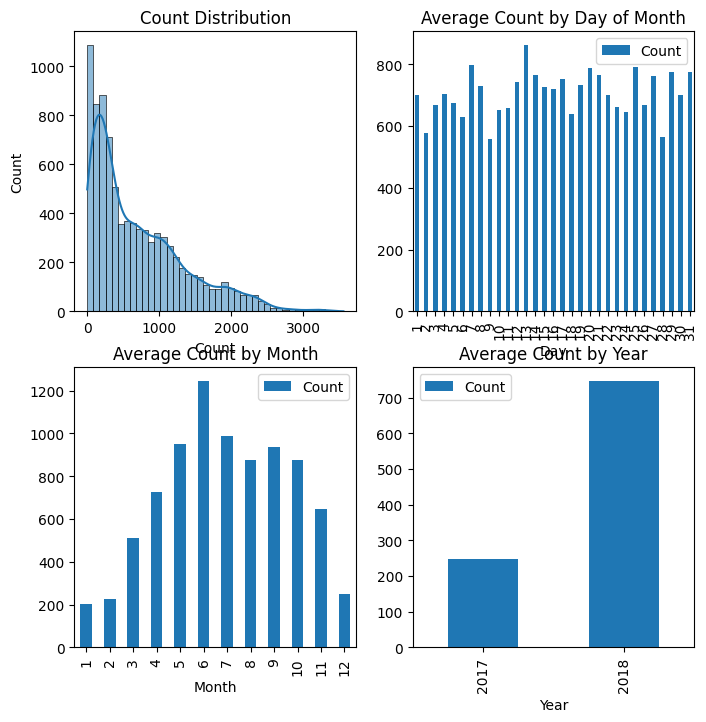

In [223]:


## plot average count over time to look for patterns that can be used to predict future demand
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year
all_data['Day'] = all_data['Date'].dt.day

## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
sns.histplot(all_data['Count'], kde=True, ax=ax[0, 0]).set_title('Count Distribution')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


In [224]:
features = ["PublicHoliday", "Weekend","Month", "Hour", "Temp", "Windspeed", "Visibility"]


## Set up representation

In [225]:
!pip install deap

In [226]:
from deap import base, creator, tools, algorithms, gp, creator
import random
import operator
from IPython import display


In [227]:
## Prepare data for training
all_data['Windspeed'] = all_data['Wind speed']
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0})
all_data['PublicHoliday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0})
## Create a new column for weekend and assign 1 if the day is a weekend and 0 if it is not from date
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0)
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})
all_data.head()

,Date,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Windspeed,PublicHoliday,Weekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.2,0,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.8,0,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,3,No,1,12,2017,1,1.0,0,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,3,No,1,12,2017,1,0.9,0,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,3,No,1,12,2017,1,2.3,0,0


In [228]:
all_data["Count"].describe()

count    8760.000000
mean      704.602055
std       644.997468
min         0.000000
25%       191.000000
50%       504.500000
75%      1065.250000
max      3556.000000
Name: Count, dtype: float64

In [229]:
## Data standardisation
from sklearn import preprocessing

# for feature in features:
scaler = preprocessing.StandardScaler()
# Fit the scaler to your data
scaler.fit(all_data[features])

# Transform the selected features
all_data[features] = scaler.transform(all_data[features])



In [230]:
class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput
        self.numHidden1 = numHidden1
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.b_i_h1 = [0] * numHidden1
        self.b_i_h2 = [0] * numHidden2
        self.b_i_output = [0] * numOutput

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feed_forward(self, inputs):

        h1 = np.dot(self.w_i_h1, inputs)             # feed input to hidden layer 1
        h1 = [h + b for h, b in zip(h1, self.b_i_h1)]

        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        h2 = np.dot(self.w_h1_h2, h1)                # feed layer 1 to hidden layer 2
        h2 = [h + b for h, b in zip(h2, self.b_i_h2)]
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        output = [o + b for o, b in zip(output, self.b_i_output)]
        return output

    # Weights get set as:
    # Weights to layer h1, h2, o
    # Biases to layer h1, h2, o
    def set_weights_linear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        # Weights (multi-dimensional arrays)

        first_slice_end = numWeights_I_H1

        self.w_i_h1 = np.array(Wgenome[:first_slice_end])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        second_slice_end = first_slice_end + numWeights_H1_H2

        self.w_h1_h2 = np.array(Wgenome[first_slice_end:second_slice_end])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        third_slice_end = second_slice_end + numWeights_H2_O

        self.w_h2_o = np.array(Wgenome[second_slice_end:third_slice_end])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

        # Biases (flat arrays for each layer)

        fourth_slice_end = third_slice_end + self.numHidden1

        self.b_i_h1 = np.array(Wgenome[third_slice_end:fourth_slice_end])

        fith_slice_end = fourth_slice_end + self.numHidden2

        self.b_i_h2 = np.array(Wgenome[fourth_slice_end:fith_slice_end])

        self.b_i_output = np.array(Wgenome[fith_slice_end:])

    def get_weights(self):
        return np.concatenate((self.w_i_h1.flatten(), self.w_h1_h2.flatten(), self.w_h2_o.flatten(), self.b_i_h1, self.b_i_h2, self.b_i_output))

In [231]:
creator.create("FitnessMax", base.Fitness, weights=(-1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [232]:
import numpy
# randomise data
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = all_data.sample(frac=0.2)
train_data = all_data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(test_data.size)

print(train_data.size)
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


35040
140160


In [233]:

## Mean absolute error: On some regression problems, the distribution of the target variable may be mostly Gaussian, but may have outliers, e.g. large or small values far from the mean value.

def eval(individual, myNet, evdata):
  myNet.set_weights_linear(individual)
  fitness = 0
  preds = []
  for i in range(len(evdata)):
    input = [evdata['PublicHoliday'][i], evdata['Weekend'][i], evdata['Month'][i], evdata['Hour'][i], evdata['Temp'][i], evdata['Windspeed'][i], evdata['Visibility'][i]]
    output = myNet.feed_forward(input)
    preds.append(output)
    fitness += (evdata['Count'][i] - output[0])**2

  return (fitness/len(evdata), r2_score(evdata["Count"].to_list(), preds))





In [234]:
toolbox.register("evaluate", eval)

toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.4)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


myNet = MLP(num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes)

baseline = toolbox.evaluate(myNet.get_weights(), myNet, train_data)
print(baseline)

(928784.2653306047, -1.2592049659710511)


In [235]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [236]:
## SANITYY CHECK
ind = toolbox.individual()
print(ind)
print(ind.fitness.values)
print(len(ind.fitness.weights))
print(len(toolbox.evaluate(ind, myNet, train_data)))
print(ind.fitness.weights)
ind.fitness.values = toolbox.evaluate(ind, myNet, train_data)

print(ind.fitness.valid)
print(myNet.set_weights_linear(ind))
# print(myNet.feedForward([-10, 4, 3, 2, 1, 5, 5]))
print(toolbox.evaluate(ind, myNet, train_data))

[0.6628724441912428, 0.6557979958616926, 0.1814499140101984, -0.7454595786708302, -0.16196774858749485, 0.8244277119531265, -0.9610606465005205, -0.2762621339648421, 0.1403975070714294, -0.477420764642835, -0.25048372328772617, 0.6860384941746722, -0.30263451617909665, 0.25519044919649847, 0.3522309423637531, 0.6292624838506484, 0.8700560526857493, 0.647050030751348, 0.31327486284943995, 0.48874857579901376, -0.473619790571018, 0.10736992966036696, -0.547530559726517, 0.282945582310693, 0.5471980434724744, -0.96495319564904, -0.8450996188648907, 0.48029636091191996, -0.6068683441415621, -0.987484044802289, -0.0182785540663033, 0.6338608984776004, -0.09440844447013097, 0.9444077839411129, -0.07983466232137859, 0.2085638407842132, -0.6199782954444126, -0.8130867976763243, 0.7700402931792163, 0.9625635513014721, 0.7765516573468705, 0.272312181498118, -0.749421860933293, -0.4837833096059263, 0.28325736420032754, 0.06497496295524163, 0.3321471235581499, -0.20503686950316058, -0.718989047560

In [237]:
logbook = tools.Logbook()
hof = tools.HallOfFame(1)
pop = toolbox.population(n=50)

In [238]:
fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [239]:
NGEN = 200

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet, train_data) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
    
    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

    gen = [g] * 100
    hof.update(pop)
    if g%5==0:
      print(record)



-- Generation 0 --
{'avg': 449689.63947427325, 'std': 449709.18005358113, 'min': -1.2139039712574484, 'max': 910160.5230285275}
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
{'avg': 431589.9209715489, 'std': 431652.68783348484, 'min': -1.157135756354383, 'max': 886822.4790851758}
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
{'avg': 389949.6469390399, 'std': 390536.2498329175, 'min': -1.03838099474294, 'max': 838001.0770082799}
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
{'avg': 324602.60907300207, 'std': 325361.0109475413, 'min': -0.7585810399388133, 'max': 722972.2065088757}
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
{'avg': 241752.82570514295, 'std': 243085.1903842827, 'min': -0.4456589815559755, 'max': 594326.4711822809}
-- Generation 21 --
-- Generation 22 --
-- Generation

KeyboardInterrupt: 

In [240]:
print(logbook)
print([i[:1] for i in hof.items[:10]])



avg   	gen	max   	min        	std   
449690	0  	910161	-1.2139    	449709
446843	1  	907997	-1.20864   	446864
443047	2  	902687	-1.19572   	443077
439478	3  	891845	-1.16935   	439508
435675	4  	896552	-1.1808    	435738
431590	5  	886822	-1.15714   	431653
426152	6  	885591	-1.15414   	426251
418348	7  	859161	-1.08985   	418440
411163	8  	869393	-1.11474   	411357
401927	9  	839547	-1.04214   	402189
389950	10 	838001	-1.03838   	390536
380260	11 	821467	-0.998163  	380786
370188	12 	802623	-0.952327  	370763
355563	13 	775045	-0.885244  	356247
338558	14 	734259	-0.786036  	339306
324603	15 	722972	-0.758581  	325361
308284	16 	686090	-0.668867  	309328
288761	17 	683234	-0.66192   	290254
272126	18 	624038	-0.517931  	273441
257706	19 	590152	-0.435505  	259193
241753	20 	594326	-0.445659  	243085
228713	21 	531965	-0.29397   	229607
220494	22 	492610	-0.198242  	221263
212196	23 	480255	-0.168188  	213133
199109	24 	467392	-0.1369    	200426
183804	25 	443994	-0.0799863 	184810
1

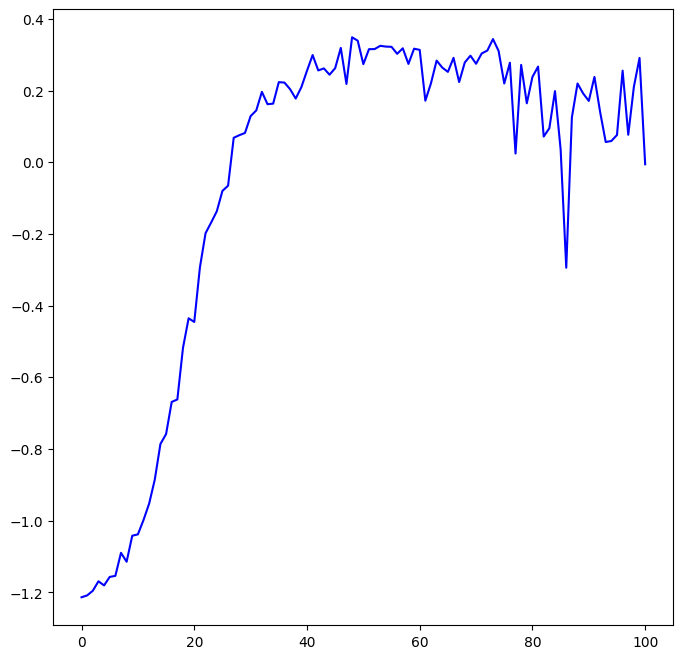

In [241]:
## graph of the min fitness value over generations
gen = logbook.select("gen")
fit_mins = logbook.select("min")
fit_maxs = logbook.select("max")
fit_avgs = logbook.select("avg")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(gen, fit_mins, "b", label="Minimum")


[[1.1795474635546104, 0.9442056109498405, -1.64241973753499, 1.3731395678055263, -0.891825248536401, 4.390096948431135, 6.620659927433406, -1.5719509769211213, 3.323143862776752, -0.7380493563272987, -0.010458023123468413, 1.7443210793658812, 3.3474744717278044, -0.5889787514628497, -2.712494272000082, -1.1935842294597527, -2.750987153290079, 3.3951676095433077, 3.275687470158542, 1.0874656669461589, 3.3478867749909007, 2.958569856446069, -5.983037048629992, -2.056428806090463, 6.019677374253782, 1.595302171898718, -1.1034568930901507, -1.8982343736710376, -0.9430088331971329, -1.1671071126714243, -2.673766002384388, 5.096139991314229, -7.924912885104272, 0.16161320090746345, 0.33313935021246555, 1.3307264903205565, -0.13037491898103604, -4.401063399259893, -0.149802520064044, 1.7781978560136993, 0.44885283188947206, -2.719727720933253, -0.7702551916978975, -0.2752978503917862, 3.451402229333792, -4.1529462152106245, 3.5998216035057657, -0.025413005437616765, -2.113821459836712, -5.365

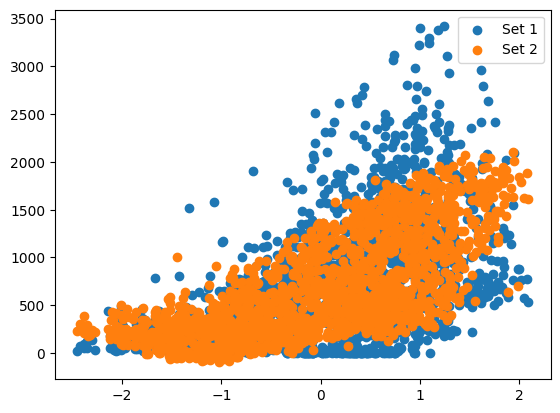

In [242]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]

print(best_ind)
print(toolbox.evaluate(best_ind[0], myNet, train_data))
myNet.set_weights_linear(best_ind[0])
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

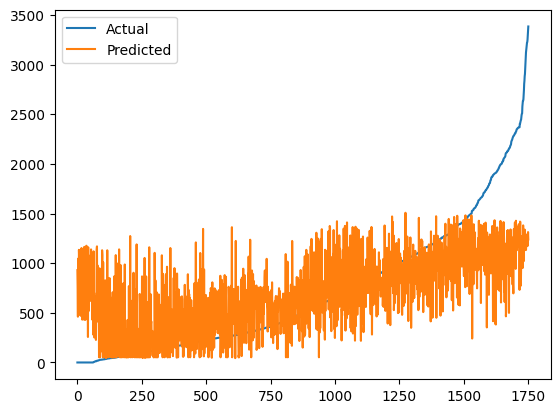

In [ ]:
best_ind = hof.items[0]

test_data.sort_values(by=['Count'], inplace=True)
test_data = test_data.reset_index(drop=True)
inputs = [[test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]
x = [i for i in range(len(test_data))]
y_values1 = test_data['Count'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs]
plt.plot(x, y_values1, label='Actual')
plt.plot(x, y_values2, label='Predicted')
plt.legend()
plt.show()

[-1.8064883428754341, -3.9265798333225437, -1.8823799855649215, -5.324537465785179, -1.7201359509124856, 7.302084807465165, -3.7230534349906415, -3.5801173308020102, 4.870073932241842, -0.9516875147305217, 1.9816617807720671, 1.66203930660329, -0.3301188786043178, -0.14642904860904965, 1.0708451022939893, 0.3452874274444697, 1.999845506056788, 3.2124533287167134, 4.648747305907465, 2.116093918405072, -3.0411621134126587, 4.073316475697847, -1.9619744061329927, 1.847721806449336, -2.877293460492272, -4.351436772850911, -9.03998903745597, -2.1333004049034234, 1.6153046017529942, -0.3767565897899512, 1.2470743576161512, 2.194376134140887, -2.0296145962891563, -0.638981923238878, -5.0597924379889765, -3.970530391424252, -2.5255392995668613, 0.8789734190290797, -6.667058306748179, -3.710666325981543, 5.295944346218073, -5.154294252915754, -7.869326282908662, -1.4373101345675157, 3.9379895476099263, -7.444415933524057, -2.9449516469022115, -11.736318463828713, -2.7259009383993824, 4.22675298

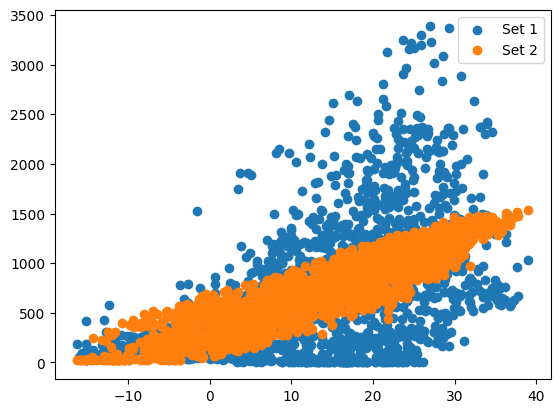

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

best_ind = hof.items[0]

print(best_ind)
print(toolbox.evaluate(best_ind, myNet, train_data))
print(toolbox.evaluate(best_ind, myNet, test_data))
myNet.set_weights_linear(best_ind)
inputs = [[test_data['Season'][i], test_data['PublicHoliday'][i], test_data['Weekend'][i], test_data['Month'][i], test_data['Hour'][i], test_data['Temp'][i], test_data['Windspeed'][i], test_data['Visibility'][i]] for i in range(len(test_data))]

x_values1 = test_data['Temp'].to_list()
y_values1 = test_data['Count'].to_list()

x_values2 = test_data['Temp'].to_list()
y_values2 = [myNet.feed_forward(i) for i in inputs] 

R2 = r2_score(y_values1, y_values2)
print(R2)
print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

[[708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337710363], [708.4970337

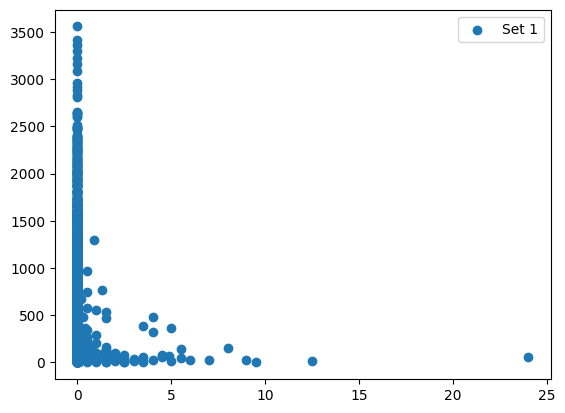

[29.096660147330937, 12.581272755715162, -0.38149388340117474, 4.957464629270712, 17.309974820025115, 11.415954409279552, -11.676366097190355, 0.046927422359391735, 9.779333286707804, 29.47839321443361, -5.395387520191839, 9.337687348597694, 14.92676670717382, -11.369634820100051, 26.64884397584116, 5.903664444034511, 15.717840450901218, 5.509973022960861, -24.074342490914763, 12.147669431831458, -5.429587036006186, 10.482114204623247, -11.919175301840948, 10.506377839387271, 1.6407556159264127, -11.942255391677476, 2.046754985028316, -4.5900594614014665, 17.106176546169976, -14.542911608606264, 4.4709820457791505, 1.5143974938124862, 12.675046211125776, 14.02482130623536, -8.205001241605178, 10.284344532687994, 9.542702385525882, 27.737329178993306, -7.330473267391048, 0.032744458846772684, -18.402472558215923, -7.099667658461653, 17.608404934296434, -4.666802491783139, -10.08339554606045, 7.750222360437842, 3.19722542153973, -5.676025704269632, -6.013707791185976, 10.8650930785805, -

In [ ]:
# Assuming you have two sets of data:
x_values1 = test_data['Rain'].to_list()
y_values1 = test_data['Count'].to_list()

# x_values2 = test_data['Rain'].to_list()
# y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
# plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()
print(best_ind)

In [ ]:
# Assuming you have two sets of data:
x_values1 = evdata['Month'].to_list()
y_values1 = evdata['Count'].to_list()

x_values2 = evdata['Month'].to_list()
y_values2 = [myNet.feedForward(i) for i in inputs] 

print(y_values2)
plt.scatter(x_values1, y_values1, label='Set 1')
plt.scatter(x_values2, y_values2, label='Set 2')

# Add a legend to explain which line is which
plt.legend()

# Display the plot
plt.show()

NameError: name 'evdata' is not defined

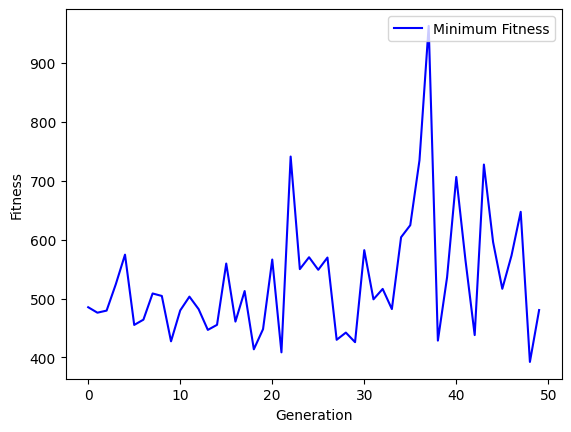

In [ ]:
## Graph fitness over generations

gen = logbook.select("gen")
fit_mins = logbook.select("min")


plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")

plt.show()